In [37]:
# let's import all the dependencies at once 

from __future__ import print_function
import itertools
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
import pandas as pd
import os

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.cross_validation import cross_val_score
from sklearn import metrics

#import models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler


#plots
import seaborn as sns
import matplotlib.pyplot as plt

ctx = mx.gpu()


In [16]:
### Read the dataset ###

my_cols = pd.read_csv("KDDlabels.csv", header = -1)

### TRAIN ###
df = pd.read_csv("KDDTrain.csv", header = -1)
df.drop(42, axis=1, inplace=True)
df.columns = my_cols[0] 

# we drop this feature because it is always the same. no information
df.drop("num_outbound_cmds", axis = 1, inplace = True)

### TEST ###
test_df = pd.read_csv("KDDTest.csv", header = -1)
test_df.drop(42, axis = 1, inplace = True)
test_df.columns = my_cols[0]

# we drop this feature because it is always the same. no information
test_df.drop("num_outbound_cmds", axis = 1, inplace = True)

In [17]:
# we add a column that keeps track if a sample comes from the test or train
df["train"] = True
test_df["train"] = False

In [18]:
# TRAIN and TEST merging
mix_df = df.append(test_df)
mix_df.shape

(148516, 42)

In [19]:
mix_df.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,train
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,True
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,True
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,True


## 2 classes ##

In [20]:
# constructing labels
mix_df.loc[~mix_df["label"].isin(["normal"]), "label"] = 1   # not DOS
mix_df.loc[mix_df["label"] == "normal", "label"] = 0   # normal connection

mix_df["label_numeric"] = pd.to_numeric(mix_df["label"])
mix_df = mix_df.drop("label", axis=1)

In [21]:
mix_df.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,train,label_numeric
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,True,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,True,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,True,1


In [22]:
cols_to_transform = ["protocol_type", "service", "flag"]    # 3 protocol_type
                                                            # 66 services
                                                            # 11 flags
        

# MIXED DATASET
restricted_mdf = mix_df.copy()
restricted_mdf = pd.get_dummies(data = restricted_mdf, columns = cols_to_transform)


In [26]:
x_darpa.dtypes.value_counts()

uint8      84
int64      22
float64    15
dtype: int64

In [24]:
test = restricted_mdf[restricted_mdf["train"] == False]
test = test.drop("train", axis = 1)
x_test = test.drop("label_numeric", axis = 1)
y_test = test["label_numeric"]

x_darpa = restricted_mdf[restricted_mdf["train"] == True]    #label_n is the numeric version
x_darpa = x_darpa.drop("train", axis = 1)
y_darpa = x_darpa["label_numeric"]
x_darpa = x_darpa.drop("label_numeric", axis = 1)

In [31]:
x_darpa["wrong_fragment"].value_counts()

0.000000    124883
1.000000       884
0.333333       206
Name: wrong_fragment, dtype: int64

In [30]:
### NORMALIZATION ###

columns_to_normalize = ["duration", "src_bytes", "dst_bytes", "wrong_fragment",
                        "urgent", "hot", "num_failed_logins",
                        "num_compromised", "su_attempted", "num_root",
                        "num_file_creations", "num_shells",
                        "num_access_files",
                        "count", "srv_count", "dst_host_count",
                        "dst_host_srv_count" ]

## TRAIN normalization
x_darpa_copy = x_darpa.copy()
x_darpa_scaled = x_darpa_copy[columns_to_normalize]
scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_darpa_scaled = scaler.transform(x_darpa_scaled.values)

x_darpa[columns_to_normalize] = x_darpa_scaled


# TEST normalization
x_test_copy = x_test.copy()
x_test_scaled = x_test_copy[columns_to_normalize]
#scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_test_scaled = scaler.transform(x_test_scaled.values)           #to transform we use the SCALER calculated in the training

x_test[columns_to_normalize] = x_test_scaled

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# MODEL

In [84]:
# divido in maniera random (comportamento di default)
x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size = 0.2, random_state = 42)

In [85]:
x_train.shape

(100778, 121)

In [86]:
batch_s = 256

train_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(x_train.as_matrix(), y_train.as_matrix()), batch_size=batch_s, shuffle=True)
cv_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(x_cv.as_matrix(), y_cv.as_matrix()), batch_size=batch_s, shuffle=False)
test_iter  = gluon.data.DataLoader(gluon.data.ArrayDataset(x_test.as_matrix(), y_test.as_matrix()),   batch_size=batch_s, shuffle=False)

In [87]:
num_outputs = 2  #quanti il numero delle classi, di certo è importante che non sia meno! 

net = gluon.nn.Sequential()

with net.name_scope():
    net.add(gluon.nn.Dense(100, activation = "relu"))
    net.add(gluon.nn.Dense(80, activation = "relu"))
    net.add(gluon.nn.Dense(80, activation = "relu"))
    net.add(gluon.nn.Dense(80, activation = "relu"))
    net.add(gluon.nn.Dense(60, activation = "relu"))
    net.add(gluon.nn.Dense(20, activation = "relu"))
    net.add(gluon.nn.Dense(num_outputs))

In [88]:
net.collect_params().initialize(mx.init.Normal(sigma = 0.5), ctx = ctx)

In [89]:
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()  # sparse_label=False per specificare one-hot

In [90]:
lr = 0.0001 # learning rate
trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": lr})

In [91]:
# hot evaluation

smoothing_constant = 0.01

def evaluate_accuracy(data_iterator, net):
    
    acc = mx.metric.Accuracy()
    
    loss_avg = 0.0
    cumulative_loss = 0.0
    
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).astype(np.float32)
        label = label.as_in_context(ctx).astype(np.float32)
        
        output = net(data)
        
        loss = loss_f(output, label) 
        predictions = nd.argmax(output, axis = 1)
        acc.update(preds = predictions, labels = label)
           
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = curr_loss if (i == 0) else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
                       
        
    return acc.get()[1], moving_loss

In [92]:
# TRAINING

epochs = 20
smoothing_constant = .01

loss_evolution_train = []
loss_evolution_cv = []
loss_evolution_test = []

accuracy_evolution_train = []
accuracy_evolution_cv = []
accuracy_evolution_test = []


for e in range(epochs):
    
    for i, (data, label) in enumerate(train_iter):
        
        data = data.as_in_context(ctx).astype(np.float32)
        label = label.as_in_context(ctx).astype(np.float32)
        
        with autograd.record():
            output = net(data)
            loss = loss_f(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        
        
    train_accuracy, train_loss = evaluate_accuracy(train_iter, net)
    cv_accuracy, cv_loss       = evaluate_accuracy(cv_iter, net)
    test_accuracy, test_loss   = evaluate_accuracy(test_iter, net)
    
    # save them for later
    loss_evolution_train.append(train_loss)
    loss_evolution_cv.append(cv_loss)
    loss_evolution_test.append(test_loss)
    
    accuracy_evolution_train.append(train_accuracy)
    accuracy_evolution_cv.append(cv_accuracy)
    accuracy_evolution_test.append(test_accuracy)
    
    #print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
    print("Epoch %s. Train_acc %s. CV_accuracy %s. Test_acc %s" % (e,  train_accuracy, cv_accuracy, test_accuracy))

Epoch 0. Train_acc 0.955605390065. CV_accuracy 0.952331811867. Test_acc 0.828017566429
Epoch 1. Train_acc 0.969497310921. CV_accuracy 0.965707481643. Test_acc 0.812757840571
Epoch 2. Train_acc 0.979023199508. CV_accuracy 0.9763445128. Test_acc 0.805039258306
Epoch 3. Train_acc 0.982277878108. CV_accuracy 0.979559436396. Test_acc 0.80495053897
Epoch 4. Train_acc 0.984212824228. CV_accuracy 0.982020242112. Test_acc 0.788005145722
Epoch 5. Train_acc 0.986316457957. CV_accuracy 0.983687239532. Test_acc 0.790223129131
Epoch 6. Train_acc 0.98669352438. CV_accuracy 0.983766620361. Test_acc 0.796389123009
Epoch 7. Train_acc 0.986762983985. CV_accuracy 0.983687239532. Test_acc 0.7970988777
Epoch 8. Train_acc 0.989471908551. CV_accuracy 0.986981543957. Test_acc 0.79661092135
Epoch 9. Train_acc 0.989968048582. CV_accuracy 0.987100615201. Test_acc 0.796566561682
Epoch 10. Train_acc 0.986316457957. CV_accuracy 0.981980551697. Test_acc 0.800514572151
Epoch 11. Train_acc 0.991992299907. CV_accuracy 0

### PLOTS

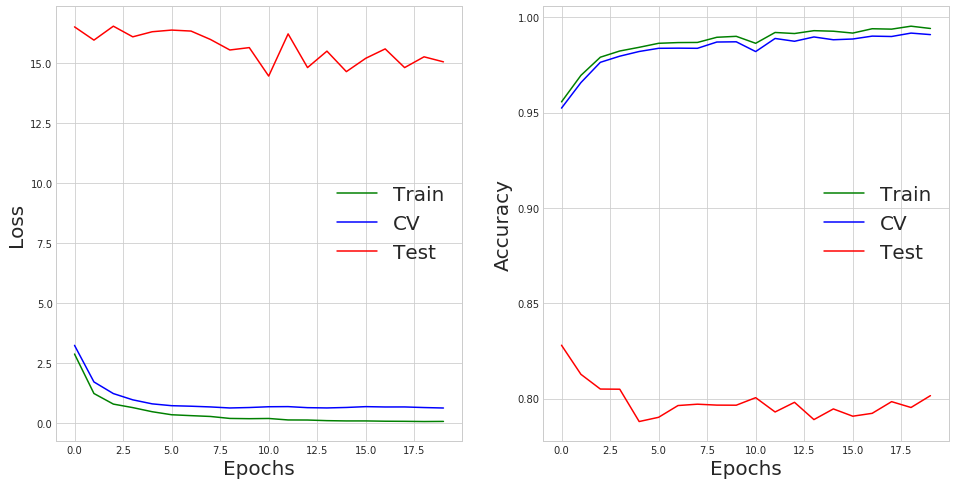

In [93]:
sns.set_style("whitegrid")

plt.figure(figsize = (16, 8))
plt.subplot(121)

plt.plot(loss_evolution_train, color = "g")
plt.plot(loss_evolution_cv, color = "b")
plt.plot(loss_evolution_test, color = "r")    # qui c'è qualcosa che non va.... le curve dovrebbero essere invertite
#plt.title("Comparing Loss Functions", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(["Train","CV", "Test"], fontsize=20)

plt.subplot(122)
plt.plot(accuracy_evolution_train, color = "g")
plt.plot(accuracy_evolution_cv, color = "b")
plt.plot(accuracy_evolution_test, color = "r")    # qui c'è qualcosa che non va.... le curve dovrebbero essere invertite
#plt.title("Comparing Accuracies", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend(["Train", "CV", "Test"], fontsize=20)

plt.show()

In [99]:
### COLD EVALUATION ###
# to be run when the neural network is trained

total_correctly_classified = 0 
total_wrongly_classified = 0

predictions_received = []
labels_received = []

for i, (data, label) in enumerate(test_iter):  # input: train_iter o anche test_iter o cv_iter
    
    currently_correctly_classified = 0
    currently_wrongly_classified = 0
    
    data = data.as_in_context(ctx).astype(np.float32)
    label = label.as_in_context(ctx).astype(np.float32)    

    
    output = net(data) #feed input in the net
    
    ground_output = nd.argmax(output, axis = 1)
    ground_truth  = label
    
    
    for x, y in zip(ground_output, ground_truth):
        
        predictions_received.append(x.asscalar())
        labels_received.append(y.asscalar())
        
        if x.asscalar() == y.asscalar():
            currently_correctly_classified += 1
        else:
            currently_wrongly_classified += 1
        
    #keep track of global trend
    total_correctly_classified += currently_correctly_classified
    total_wrongly_classified += currently_wrongly_classified   
    
    #resetting variables for next iteration
    currently_correctly_classified = 0
    currently_wrongly_classified = 0
    
print("Total correctly classified samples: %s. Total wrongly classified samples: %s. " %(total_correctly_classified, total_wrongly_classified))

Total correctly classified samples: 18070. Total wrongly classified samples: 4473. 


In [100]:
cm_cv = cmatrix(labels_received, predictions_received).T

In [98]:
cm_cv

array([[13325,   107],
       [   97, 11666]])

In [101]:
cm_cv

array([[9342, 4105],
       [ 368, 8728]])

### confidence evaluation

In [163]:
# si puo' mettere x_cv o x_test
eval_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(x_test.as_matrix(), y_test.as_matrix()), batch_size = 1, shuffle = False)


vals_first_neuron = []
vals_second_neuron = []
vals_pred = []

for i, (data, label) in enumerate(eval_iter):
    
    data = data.as_in_context(ctx).astype(np.float32)
    
    output = net(data)
    prediction = nd.argmax(output, axis = 1)
    #print(prediction.asscalar())
    
    vals_first_neuron.append(output.asnumpy()[0][0])
    vals_second_neuron.append(output.asnumpy()[0][1])
    vals_pred.append(int(prediction.asscalar()))

    
# have to change here too
sys = pd.DataFrame(data = x_test.index.values, columns=["index"])
sys["neuron1"] = vals_first_neuron
sys["neuron2"] = vals_second_neuron
sys["prediction"] = vals_pred
sys["truth"] = y_test.values

In [164]:
sys.head(5)

,index,neuron1,neuron2,prediction,truth
0,0,3.149495,269.934418,1,1
1,1,4.688855,300.828735,1,1
2,2,369.394470,290.646606,0,0
3,3,59.072968,128.624832,1,1
4,4,-60.678352,-72.065010,0,1


In [165]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [166]:
# adding two column with PROBABILITIES for neuron1 and neuron2.

prob_neuron_one = []
prob_neuron_two = []
for x,y in zip(sys["neuron1"], sys["neuron2"]):

    tmp = softmax([x,y])

    prob_neuron_one.append(tmp[0])
    prob_neuron_two.append(tmp[1])
    
    
sys["neuron1_prob"] = prob_neuron_one
sys["neuron2_prob"] = prob_neuron_two

In [167]:
sys.head(5)

,index,neuron1,neuron2,prediction,truth,neuron1_prob,neuron2_prob
0,0,3.149495,269.934418,1,1,1.370188e-116,1.000000e+00
1,1,4.688855,300.828735,1,1,2.443903e-129,1.000000e+00
2,2,369.394470,290.646606,0,0,1.000000e+00,6.313022e-35
3,3,59.072968,128.624832,1,1,6.223132e-31,1.000000e+00
4,4,-60.678352,-72.065010,0,1,9.999887e-01,1.134573e-05


In [168]:
# let's have a look to the wrong classified samples

sys[sys["prediction"] != sys["truth"]]

,index,neuron1,neuron2,prediction,truth,neuron1_prob,neuron2_prob
4,4,-60.678352,-72.065010,0,1,9.999887e-01,1.134573e-05
7,7,418.039062,243.775330,0,1,1.000000e+00,2.080762e-76
9,9,122.904404,57.081997,0,1,1.000000e+00,2.592340e-29
10,10,226.543259,142.599075,0,1,1.000000e+00,3.495460e-37
33,33,28.762581,161.792816,1,0,1.681523e-58,1.000000e+00
37,37,114.537239,55.040909,0,1,1.000000e+00,1.449012e-26
54,54,117.853584,38.132355,0,1,1.000000e+00,2.385118e-35
57,57,142.094025,15.556202,0,1,1.000000e+00,1.109997e-55
58,58,427.553131,270.937958,0,1,1.000000e+00,9.613786e-69
60,60,364.183014,286.489502,0,1,1.000000e+00,1.811909e-34
